# HRV4Training Health and Fitness Data Analysis

This is a rough draft data analysis notebook. Provides a starting point to looking at your data from HRV4Training. 

----

In [1]:
from datetime import date, datetime as dt, timedelta as td
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

------

## Data Processing

In [3]:
# import data
hrv = pd.read_csv('data/hrv4training.csv')

# data processing
hrv.columns = ['date', 'timestamp_measurement', 'HR', 'AVNN', 'SDNN', 'rMSSD', 'pNN50',
       'LF', 'HF', 'LFHF', 'test_duration', 'HRV4T_Recovery_Points',
       'training', 'training_performance', 'training_type', 'training_phase',
       'physical_condition', 'trainingRPE', 'trainingTSS', 'suffer_score',
       'trainingMotivation', 'trainingDistance', 'sleep_quality',
       'sleep_time', 'sleep_tobed', 'sleep_awake', 'mental_energy',
       'muscle_soreness', 'fatigue', 'traveling', 'sickness', 'alcohol',
       'baseline', 'advice', 'note', 'signal_quality', 'location',
       'supplements', 'diet', 'custom_tag_1_name', 'custom_tag_2_name',
       'custom_tag_3_name', 'custom_tag_1_value', 'custom_tag_2_value',
       'custom_tag_3_value', 'menstrual_cycle', 'trainingTime',
       'current_lifestyle', 'run_distance', 'run_time', 'run_pace',
       'run_hr', 'run_elevation', 'bike_distance', 'bike_time',
       'bike_speed', 'bike_elevation', ' bike_hr', 'bike_power',
       'swim_distance', 'swim_time', 'swim_speed', 'swim_hr', 'vo2max',
       'latitude', 'longitude', 'altitude', 'temperature', 'humidity',
       'daily_message']

# cleanup
hrv.replace('- ','', inplace=True)
hrv.replace(' -','', inplace=True)
hrv.replace('-','', inplace=True)

# convert to numeric
hrv["HRV4T_Recovery_Points"] = pd.to_numeric(hrv["HRV4T_Recovery_Points"])
hrv["rMSSD"] = pd.to_numeric(hrv["rMSSD"])
hrv["baseline"] = pd.to_numeric(hrv["baseline"])
hrv["latitude"] = pd.to_numeric(hrv["latitude"])
hrv["longitude"] = pd.to_numeric(hrv["longitude"])

# binary for sickness
hrv['sick'] = np.where(hrv['sickness'] == 'sick', '1', '0')
hrv['sick'] = pd.to_numeric(hrv['sick'])

# binary for travel
hrv['travel'] = np.where(hrv['traveling'] == 'traveling', '1', '0')
hrv['travel'] = pd.to_numeric(hrv['travel'])

# alcohol drinking level
def drinking_level(df):
    if (df['alcohol'] == 'nothing'):
        return 0
    elif (df['alcohol'] == 'a little'):
        return 1
    elif (df['alcohol'] == 'too much'):
        return 2
hrv['drinking'] = hrv.apply(drinking_level, axis = 1)

# date dimensions
hrv['date'] = pd.to_datetime(hrv['date'])
hrv['just_date'] = hrv['date'].dt.date
hrv['year'] = hrv['date'].dt.year
hrv['month'] = hrv['date'].dt.month
hrv['mnth_yr'] = hrv['date'].apply(lambda x: x.strftime('%Y-%m'))
hrv['day'] = hrv['date'].dt.day
hrv['dow'] = hrv['date'].dt.weekday

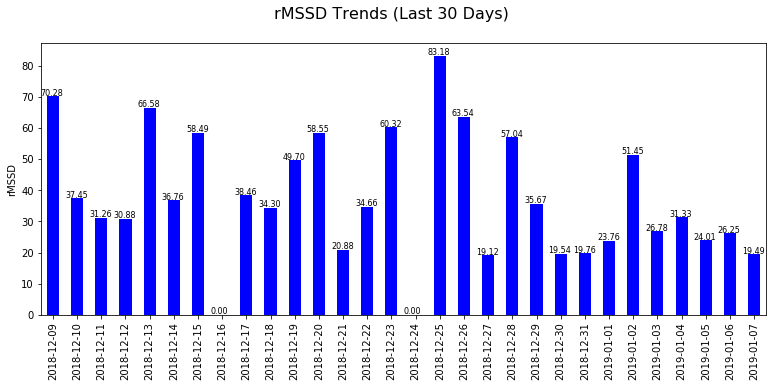

In [4]:
# rMSSD
ax = hrv.tail(30).plot.bar(x='just_date', y='rMSSD', figsize=[13, 5], colormap='winter', legend=False)
plt.suptitle('rMSSD Trends (Last 30 Days)', fontsize=16)
x_offset = -0.5
y_offset = 0.25
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=8)
ax.set_xlabel('')
ax.set_ylabel("rMSSD")

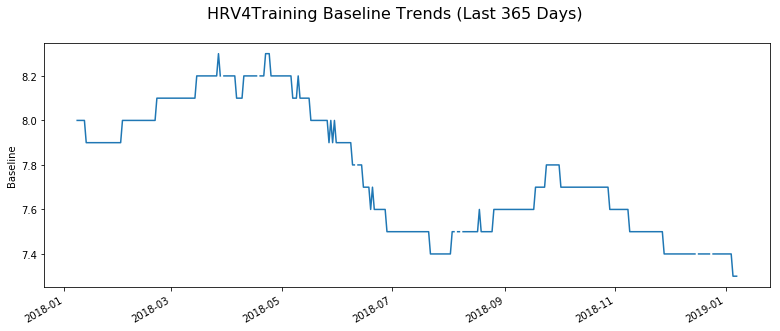

In [5]:
# baseline
ax = hrv.tail(365).plot(x='date', y='baseline', figsize=[13, 5], legend=False)
plt.suptitle('HRV4Training Baseline Trends (Last 365 Days)', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("Baseline")

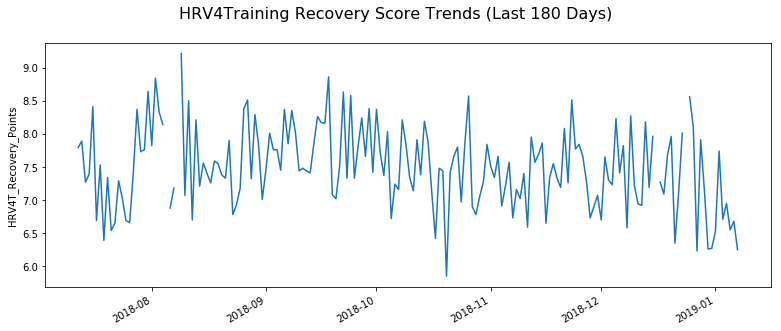

In [6]:
# HRV4T_Recovery_Points
ax = hrv.tail(180).plot(x='date', y='HRV4T_Recovery_Points', figsize=[13, 5], legend=False)
plt.suptitle('HRV4Training Recovery Score Trends (Last 180 Days)', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("HRV4T_Recovery_Points")

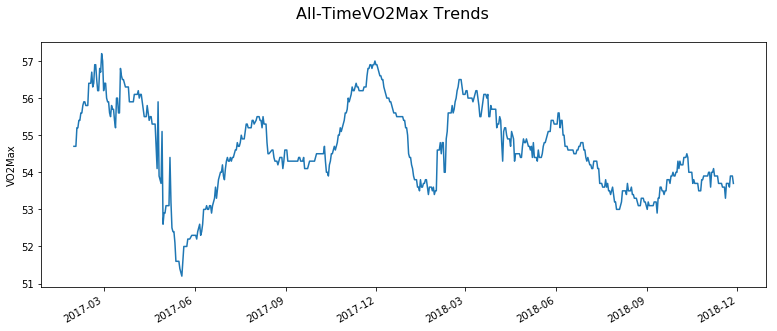

In [7]:
# VO2 Max
ax = hrv[hrv.vo2max > 0].plot(x='date', y='vo2max', figsize=[13, 5], legend=False)
plt.suptitle('All-TimeVO2Max Trends', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("VO2Max")

In [8]:
hrv[(hrv.year == 2018) & (hrv.vo2max > 0)].vo2max.mean()

54.36993865030678

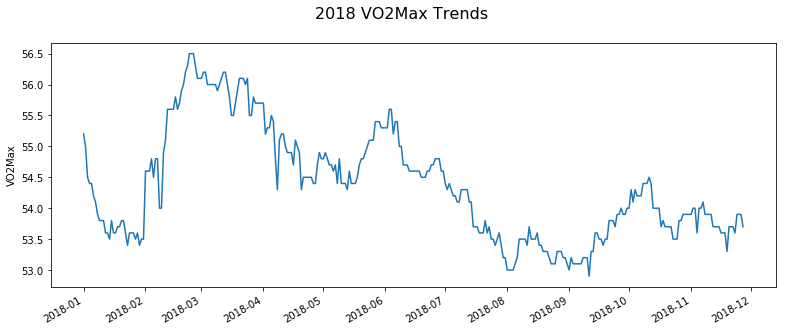

In [9]:
# VO2 Max
ax = hrv[(hrv.year == 2018) & (hrv.vo2max > 0)].plot(x='date', y='vo2max', figsize=[13, 5], legend=False)
plt.suptitle('2018 VO2Max Trends', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("VO2Max")

In [10]:
# Helper Function to Create Heat Map from Data
# Adapted from https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap
DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

In [11]:
def year_sick_heat_chart(year):   

    # Filter by Year
    year_data = hrv[(hrv['year'] == year)]
    
    # daily sleep
    year_dates_data = year_data.groupby(['date'])['sick'].sum().reset_index()
    year_dates_data.columns = ['date', 'sick']
    year_dates_data['date'] = pd.to_datetime(year_dates_data['date'])

    # Generate all dates in that year
    first_date = str(year)+'-01-01'
    last_date = str(year)+'-12-31'
    all_dates = pd.date_range(start=first_date, end=last_date)
    all_dates = pd.DataFrame(all_dates, columns=['date'])
    
    # combine actual runs by date with total dates possible
    year_data = pd.merge(left=all_dates, right=year_dates_data, 
                                 left_on="date", right_on="date", how="outer")
    year_data['sick'].fillna(0, inplace=True)
    year_data = year_data.set_index(pd.DatetimeIndex(year_data['date']))
    
    max_daily_count = round(year_data['sick'].max(),2)
    
    # key stat and title
    #averageSleep = round(year_dates_data['Hours'].mean(),2)
    #chart_title = '{} Sleep Heatmap | Nightly Average: {:,} hours'.format(year, averageSleep)
    
    # set chart data
    data = year_data['sick']
    data.index = year_data.index 
    
    # plot data
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)
    ax = date_heatmap(data, edgecolor='black')
    max_count = int(round(data.max(),0))
    min_count = int(round(data.min(),0))
    steps = int(round(max_count / 6, 0))
    plt.colorbar(ticks=range(min_count, max_count, steps), pad=0.02)
    cmap = mpl.cm.get_cmap('Purples', max_daily_count)
    plt.set_cmap(cmap)
    plt.clim(min_count, max_daily_count)
    ax.set_aspect('equal')
    ax.set_title(chart_title)
    plt.show()

In [12]:
# year_sick_heat_chart(year=2018)

In [13]:
# year_sick_heat_chart(year=2017)

In [14]:
def year_travel_heat_chart(year):   

    # Filter by Year
    year_data = hrv[(hrv['year'] == year)]
    
    # daily sleep
    year_dates_data = year_data.groupby(['date'])['travel'].sum().reset_index()
    year_dates_data.columns = ['date', 'travel']
    year_dates_data['date'] = pd.to_datetime(year_dates_data['date'])

    # Generate all dates in that year
    first_date = str(year)+'-01-01'
    last_date = str(year)+'-12-31'
    all_dates = pd.date_range(start=first_date, end=last_date)
    all_dates = pd.DataFrame(all_dates, columns=['date'])
    
    # combine actual runs by date with total dates possible
    year_data = pd.merge(left=all_dates, right=year_dates_data, 
                                 left_on="date", right_on="date", how="outer")
    year_data['travel'].fillna(0, inplace=True)
    year_data = year_data.set_index(pd.DatetimeIndex(year_data['date']))
    
    max_daily_count = round(year_data['travel'].max(),2)
    
    # key stat and title
    #averageSleep = round(year_dates_data['Hours'].mean(),2)
    #chart_title = '{} Sleep Heatmap | Nightly Average: {:,} hours'.format(year, averageSleep)
    
    # set chart data
    data = year_data['travel']
    data.index = year_data.index 
    
    # plot data
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)
    ax = date_heatmap(data, edgecolor='black')
    max_count = int(round(data.max(),0))
    min_count = int(round(data.min(),0))
    steps = int(round(max_count / 6, 0))
    cmap = mpl.cm.get_cmap('Reds', max_daily_count)
    plt.colorbar(ticks=range(min_count, max_count, steps), pad=0.02)
    plt.set_cmap(cmap)
    plt.clim(min_count, max_daily_count)
    ax.set_aspect('equal')
    ax.set_title(chart_title)
    plt.show()

In [15]:
# year_travel_heat_chart(year=2018)

In [16]:
# year_travel_heat_chart(year=2017)

In [17]:
def year_drinking_heat_chart(year):   

    # Filter by Year
    year_data = hrv[(hrv['year'] == year)]
    
    # daily sleep
    year_dates_data = year_data.groupby(['date'])['drinking'].sum().reset_index()
    year_dates_data.columns = ['date', 'drinking']
    year_dates_data['date'] = pd.to_datetime(year_dates_data['date'])

    # Generate all dates in that year
    first_date = str(year)+'-01-01'
    last_date = str(year)+'-12-31'
    all_dates = pd.date_range(start=first_date, end=last_date)
    all_dates = pd.DataFrame(all_dates, columns=['date'])
    
    # combine actual runs by date with total dates possible
    year_data = pd.merge(left=all_dates, right=year_dates_data, 
                                 left_on="date", right_on="date", how="outer")
    year_data['drinking'].fillna(0, inplace=True)
    year_data = year_data.set_index(pd.DatetimeIndex(year_data['date']))
    
    max_daily_count = round(year_data['drinking'].max(),2)
    
    # key stat and title
    #averageSleep = round(year_dates_data['Hours'].mean(),2)
    #chart_title = '{} Sleep Heatmap | Nightly Average: {:,} hours'.format(year, averageSleep)
    
    # set chart data
    data = year_data['drinking']
    data.index = year_data.index 
    
    # plot data
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)
    ax = date_heatmap(data, edgecolor='black')
    max_count = int(round(data.max(),0))
    min_count = int(round(data.min(),0))
    steps = int(round(max_count / 6, 0))
    cmap = mpl.cm.get_cmap('Reds', max_daily_count)
    plt.colorbar(ticks=range(min_count, max_count, steps), pad=0.02)
    plt.set_cmap(cmap)
    plt.clim(min_count, max_daily_count)
    ax.set_aspect('equal')
    ax.set_title(chart_title)
    plt.show()

In [18]:
# year_drinking_heat_chart(year=2018)

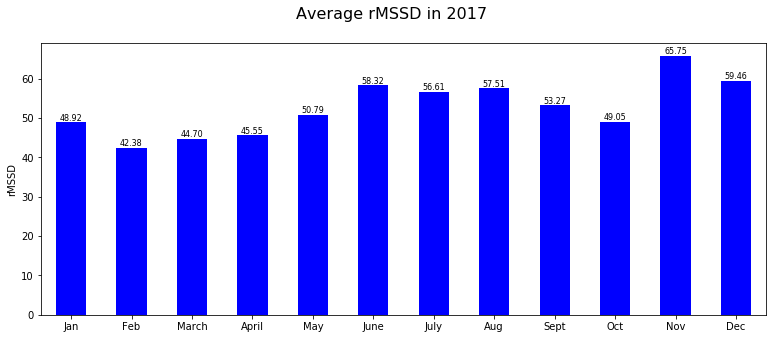

In [19]:
# data = sleep.groupby(['dow'])['Hours'].mean()
monthly_rMSSD = hrv[hrv.year == 2017].groupby('mnth_yr')['rMSSD'].mean() #.reset_index()

months_of_year = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 
                      'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
monthly_rMSSD.index = months_of_year

# rMSSD
ax = monthly_rMSSD.plot.bar(figsize=[13, 5], rot=0, colormap='winter', legend=False)
plt.suptitle('Average rMSSD in 2017', fontsize=16)
x_offset = -0.19
y_offset = 0.45
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=8)
ax.set_xlabel('')
ax.set_ylabel("rMSSD")

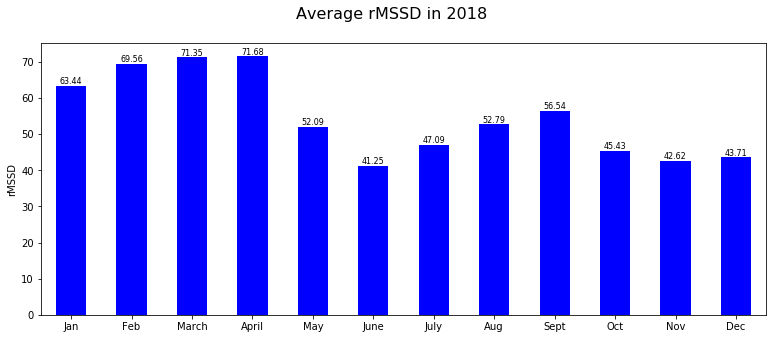

In [20]:
# data = sleep.groupby(['dow'])['Hours'].mean()
monthly_rMSSD = hrv[hrv.year == 2018].groupby('mnth_yr')['rMSSD'].mean() #.reset_index()

months_of_year = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 
                      'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
monthly_rMSSD.index = months_of_year

# rMSSD
ax = monthly_rMSSD.plot.bar(figsize=[13, 5], rot=0, colormap='winter', legend=False)
plt.suptitle('Average rMSSD in 2018', fontsize=16)
x_offset = -0.19
y_offset = 0.45
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=8)
ax.set_xlabel('')
ax.set_ylabel("rMSSD")

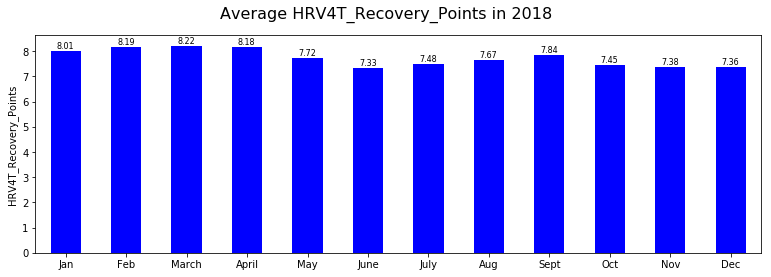

In [21]:
# data = sleep.groupby(['dow'])['Hours'].mean()
monthly_HRV4T_Recovery_Points = hrv[hrv.year == 2018].groupby('mnth_yr')['HRV4T_Recovery_Points'].mean() #.reset_index()

months_of_year = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 
                      'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
monthly_HRV4T_Recovery_Points.index = months_of_year


# rMSSD
ax = monthly_HRV4T_Recovery_Points.plot.bar(figsize=[13, 4], rot=0, colormap='winter', legend=False)
plt.suptitle('Average HRV4T_Recovery_Points in 2018', fontsize=16)
x_offset = -0.15
y_offset = 0.10
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=8)
ax.set_xlabel('')
ax.set_ylabel("HRV4T_Recovery_Points")


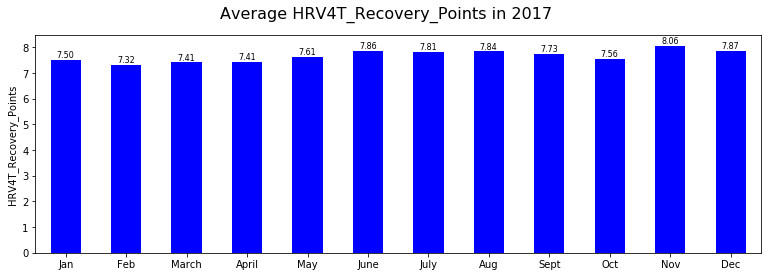

In [22]:
# data = sleep.groupby(['dow'])['Hours'].mean()
monthly_HRV4T_Recovery_Points = hrv[hrv.year == 2017].groupby('mnth_yr')['HRV4T_Recovery_Points'].mean() #.reset_index()

months_of_year = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 
                      'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
monthly_HRV4T_Recovery_Points.index = months_of_year


# rMSSD
ax = monthly_HRV4T_Recovery_Points.plot.bar(figsize=[13, 4], rot=0, colormap='winter', legend=False)
plt.suptitle('Average HRV4T_Recovery_Points in 2017', fontsize=16)
x_offset = -0.15
y_offset = 0.10
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=8)
ax.set_xlabel('')
ax.set_ylabel("HRV4T_Recovery_Points")


In [23]:
hrv[(hrv['year'] == 2018)]['sickness'].value_counts().sort_index()

not sick    363
sick          2
Name: sickness, dtype: int64

In [24]:
hrv[(hrv['year'] == 2017)]['sickness'].value_counts().sort_index()

not sick    358
sick          5
Name: sickness, dtype: int64

a little    152
nothing     196
too much     17
Name: alcohol, dtype: int64

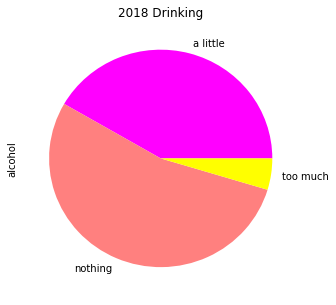

In [25]:
hrv[(hrv['year'] == 2018)]['alcohol'].value_counts().sort_index().plot.pie(figsize=[5, 5], title='2018 Drinking', colormap='spring', legend=False)
hrv[(hrv['year'] == 2018)]['alcohol'].value_counts().sort_index()

a little    120
nothing     224
too much     19
Name: alcohol, dtype: int64

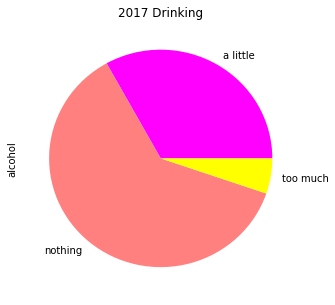

In [26]:
hrv[(hrv['year'] == 2017)]['alcohol'].value_counts().sort_index().plot.pie(figsize=[5, 5], title='2017 Drinking', colormap='spring', legend=False)
hrv[(hrv['year'] == 2017)]['alcohol'].value_counts().sort_index()

In [27]:
hrv[(hrv['year'] == 2018)]['traveling'].value_counts().sort_index()

not traveling    333
traveling         32
Name: traveling, dtype: int64

In [28]:
hrv[(hrv['year'] == 2017)]['traveling'].value_counts().sort_index()

not traveling    310
traveling         53
Name: traveling, dtype: int64

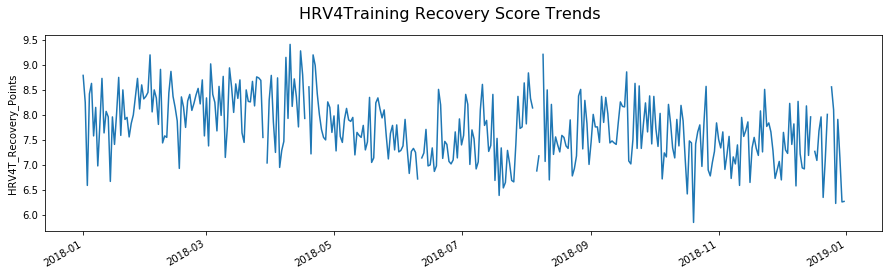

In [29]:
# HRV4T_Recovery_Points
ax = hrv[hrv['year'] == 2018].plot(x='date', y='HRV4T_Recovery_Points', figsize=[15, 4], legend=False)
plt.suptitle('HRV4Training Recovery Score Trends', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("HRV4T_Recovery_Points")

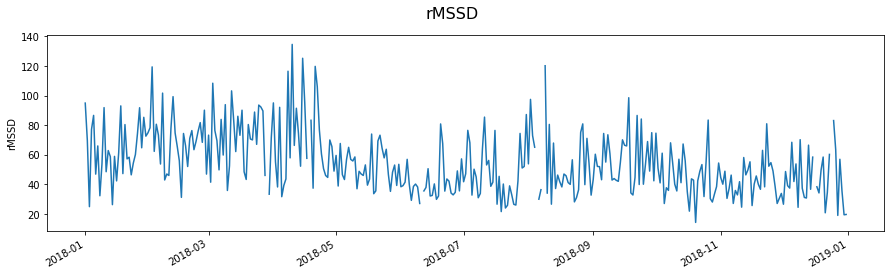

In [30]:
# HRV4T_Recovery_Points
ax = hrv[hrv['year'] == 2018].plot(x='date', y='rMSSD', figsize=[15, 4], legend=False)
plt.suptitle('rMSSD', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("rMSSD")